# Food Delivery Time Prediction – End‑to‑End ML Pipeline

This notebook builds a complete machine‑learning workflow to predict **delivery time (minutes)** for food orders.  
It covers:
- Basic data checks and exploratory previews
- Robust preprocessing (imputation, scaling, one‑hot encoding)
- Feature engineering
- Model training and comparison (Random Forest, Gradient Boosting, XGBoost, LightGBM, Ridge, Lasso)
- Hyperparameter tuning with cross‑validation
- Final evaluation, error analysis, and feature importance
- Model persistence and a reusable prediction function

> **Note:** Place `Food_Delivery_Times.csv` in the same folder as this notebook before running.


In [1]:
# ===== Imports & Setup =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

# Optional gradient boosting libraries (install if missing)
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

try:
    from lightgbm import LGBMRegressor
except Exception:
    LGBMRegressor = None

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Environment ready.')


Environment ready.


In [2]:
# ===== Load Data =====
DATA_PATH = 'Food_Delivery_Times.csv'  # make sure the file is available in the same directory

try:
    data = pd.read_csv(DATA_PATH)
    print('Data loaded successfully.')
    print('Shape:', data.shape)
except FileNotFoundError:
    raise FileNotFoundError(f'Could not find {DATA_PATH}. Please make sure it exists next to this notebook.')


Data loaded successfully.
Shape: (1000, 9)


In [3]:
# ===== Basic Data Inspection =====
print('\nData Info:')
print(data.info())

print('\nUnique values per column:')
print(data.nunique())

print('\nMissing values per column (before processing):')
print(data.isnull().sum())

# Optional quick peek
display(data.head())



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB
None

Unique values per column:
Order_ID                  1000
Distance_km                785
Weather                      5
Traffic_Level                3
Time_of_Day                  4
Vehicle_Type                 3
Preparation_Time_mi

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [4]:
# ===== Train/Test Split and Preprocessing Setup =====
# Target & features
X = data.drop(['Order_ID', 'Delivery_Time_min'], axis=1)
y = data['Delivery_Time_min']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=None
)

# Identify numeric and categorical features (update if your schema differs)
numeric_features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']

# Numeric transformer: median imputation + standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: most_frequent imputation + one-hot encoding
# sklearn >=1.2 uses 'sparse_output', while older versions use 'sparse'.
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Full preprocessing pipeline (no model yet)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit on train, transform train/test
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Recover feature names after one-hot encoding
ohe_step = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = list(ohe_step.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_feature_names

# Convert to DataFrame for readability / further engineering
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed  = pd.DataFrame(X_test_processed,  columns=feature_names, index=X_test.index)

print('Preprocessing complete. Processed feature matrix shapes:', X_train_processed.shape, X_test_processed.shape)


Preprocessing complete. Processed feature matrix shapes: (800, 18) (200, 18)


In [5]:
# ===== Feature Engineering =====
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create additional interaction and ratio features.

    Notes:
    - Operates on the *processed* feature matrix (scaled numeric + one-hot categoricals).
    - Adds:
      * distance_prep_interaction = Distance_km * Preparation_Time_min
      * prep_to_distance_ratio   = Preparation_Time_min / (Distance_km + 1e-3)
      * courier_experience_group = binned version of Courier_Experience_yrs
    """
    df_copy = df.copy()

    # Interaction between distance and preparation time
    df_copy['distance_prep_interaction'] = df_copy['Distance_km'] * df_copy['Preparation_Time_min']

    # Ratio of prep time to distance
    df_copy['prep_to_distance_ratio'] = df_copy['Preparation_Time_min'] / (df_copy['Distance_km'] + 1e-3)

    # Bucket the courier's experience
    df_copy['courier_experience_group'] = pd.cut(
        df_copy['Courier_Experience_yrs'],
        bins=[-1, 1, 3, 5, 10, 100],
        labels=['Beginner', 'Novice', 'Intermediate', 'Experienced', 'Expert']
    )

    # One-hot encode this new categorical feature to keep everything numeric
    df_copy = pd.get_dummies(df_copy, columns=['courier_experience_group'], drop_first=False)

    return df_copy

X_train_enhanced = create_features(X_train_processed)
X_test_enhanced = create_features(X_test_processed)

print('Feature engineering complete:', X_train_enhanced.shape, X_test_enhanced.shape)


Feature engineering complete: (800, 25) (200, 25)


In [6]:
# ===== Define Candidate Models =====
models = {}

models['Random Forest'] = RandomForestRegressor(random_state=RANDOM_STATE)
models['Gradient Boosting'] = GradientBoostingRegressor(random_state=RANDOM_STATE)

if XGBRegressor is not None:
    models['XGBoost'] = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)
else:
    print('XGBoost not available; skipping.')

if LGBMRegressor is not None:
    models['LightGBM'] = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
else:
    print('LightGBM not available; skipping.')

# Linear baselines
models['Ridge'] = Ridge(random_state=RANDOM_STATE)
models['Lasso'] = Lasso(random_state=RANDOM_STATE)

print('Models defined:', list(models.keys()))


Models defined: ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'Ridge', 'Lasso']


In [7]:
# ===== Quick Train & Holdout Evaluation =====
results = {}

for name, model in models.items():
    model.fit(X_train_enhanced, y_train)
    y_pred = model.predict(X_test_enhanced)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}")

# Pick the model with the highest R2
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest (by R2): {best_model_name} with R2={results[best_model_name]['R2']:.4f}")


Random Forest: MAE=7.08, RMSE=10.07, R2=0.7739
Gradient Boosting: MAE=6.95, RMSE=9.89, R2=0.7818
XGBoost: MAE=7.68, RMSE=11.08, R2=0.7263
LightGBM: MAE=7.65, RMSE=10.60, R2=0.7493
Ridge: MAE=6.10, RMSE=8.98, R2=0.8201
Lasso: MAE=7.23, RMSE=10.28, R2=0.7643

Best (by R2): Ridge with R2=0.8201


In [8]:
# ===== Hyperparameter Tuning (RandomizedSearchCV) =====
# Build parameter distributions for the chosen model
if best_model_name == 'Random Forest':
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 0.7, 0.9]
    }
    model = RandomForestRegressor(random_state=RANDOM_STATE)

elif best_model_name == 'Gradient Boosting':
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)

elif best_model_name == 'XGBoost' and XGBRegressor is not None:
    param_distributions = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'subsample': [0.7, 0.8, 1.0]
    }
    model = XGBRegressor(random_state=RANDOM_STATE, verbosity=0)

elif best_model_name == 'LightGBM' and LGBMRegressor is not None:
    param_distributions = {
        'n_estimators': [200, 400, 600],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100, 150],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
    model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

elif best_model_name == 'Ridge':
    param_distributions = {
        'alpha': np.logspace(-3, 3, 25),
        'solver': ['auto', 'sag', 'saga', 'lbfgs']
    }
    model = Ridge(random_state=RANDOM_STATE)

elif best_model_name == 'Lasso':
    param_distributions = {
        'alpha': np.logspace(-3, 2, 25),
        'max_iter': [1000, 5000, 10000],
        'selection': ['cyclic', 'random']
    }
    model = Lasso(random_state=RANDOM_STATE)

else:
    # Fallback: use Gradient Boosting
    print('No specific grid found; falling back to Gradient Boosting.')
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)

# Randomized search
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=25,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search.fit(X_train_enhanced, y_train)

print(f"\nBest params for {best_model_name}:\n", search.best_params_)
print(f"Best CV R2: {search.best_score_:.4f}")

best_model = search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best params for Ridge:
 {'solver': 'auto', 'alpha': np.float64(0.5623413251903491)}
Best CV R2: 0.7494


Final model performance on the holdout test set:
MAE:  6.10
MSE:  80.65
RMSE: 8.98
R2:   0.8201
Feature importances are not available for this model.


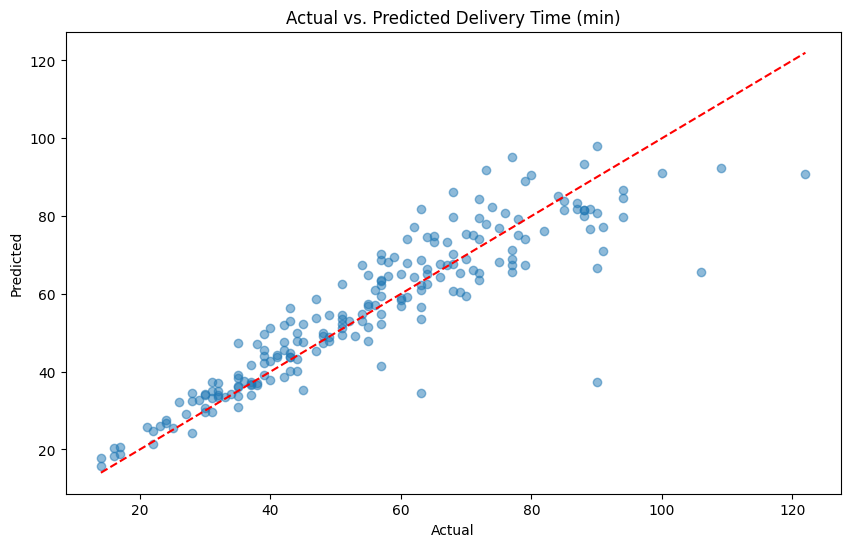

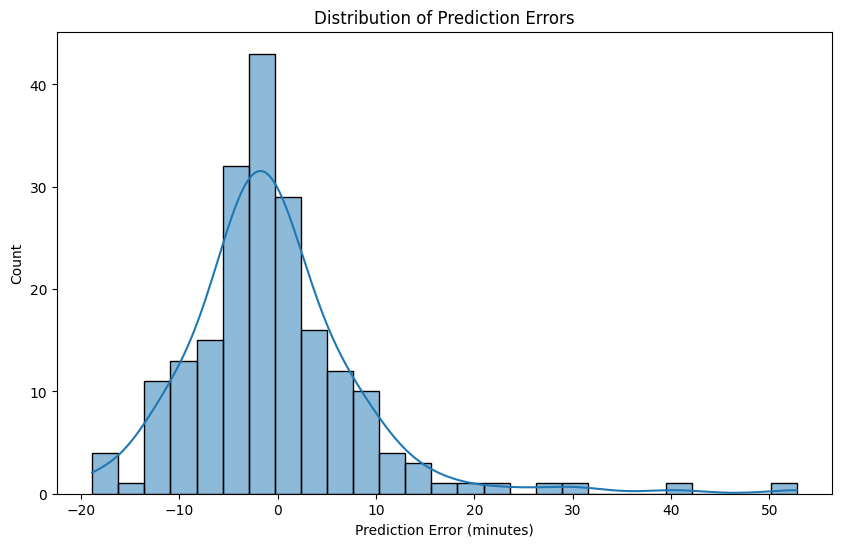

In [9]:
# ===== Final Evaluation =====
y_pred = best_model.predict(X_test_enhanced)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Final model performance on the holdout test set:')
print(f'MAE:  {mae:.2f}')
print(f'MSE:  {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2:   {r2:.4f}')

# Feature importance (tree-based models only)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_enhanced.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print('Feature importances are not available for this model.')

# Actual vs Predicted scatter
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Delivery Time (min)')
plt.show()

# Error distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error (minutes)')
plt.title('Distribution of Prediction Errors')
plt.show()


In [10]:
# ===== Cross-Validation & Overfitting Check =====
cv_scores = cross_val_score(best_model, X_train_enhanced, y_train, cv=5, scoring='r2')
print(f'CV R2 scores: {cv_scores}')
print(f'Mean R2: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})')

train_score = best_model.score(X_train_enhanced, y_train)
test_score = best_model.score(X_test_enhanced, y_test)
gap = abs(train_score - test_score)

print(f'\nTrain R2: {train_score:.4f}')
print(f'Test  R2: {test_score:.4f}')
print(f'Gap:       {gap:.4f}')

if gap > 0.10:
    print('Warning: potential overfitting detected. Consider stronger regularization, more data, or simpler models.')
else:
    print('Generalization looks reasonable.')


CV R2 scores: [0.8027844  0.68306855 0.77298588 0.70781281 0.78044239]
Mean R2: 0.7494 (±0.0916)

Train R2: 0.7616
Test  R2: 0.8201
Gap:       0.0585
Generalization looks reasonable.


In [11]:
# ===== Persist Model & Pipeline =====
artifacts = {
    'model': best_model,
    'pipeline': pipeline,
    'feature_names': list(X_train_enhanced.columns)  # include engineered columns
}
joblib.dump(artifacts, 'delivery_time_model.pkl')
print('Saved model artifacts to delivery_time_model.pkl')


Saved model artifacts to delivery_time_model.pkl


In [12]:
# ===== Reusable Prediction Function & Example =====
def create_features_for_new_data(processed_df: pd.DataFrame) -> pd.DataFrame:
    """Apply the same feature engineering steps used during training to new processed data."""
    df = processed_df.copy()
    df['distance_prep_interaction'] = df['Distance_km'] * df['Preparation_Time_min']
    df['prep_to_distance_ratio'] = df['Preparation_Time_min'] / (df['Distance_km'] + 1e-3)
    df['courier_experience_group'] = pd.cut(
        df['Courier_Experience_yrs'],
        bins=[-1, 1, 3, 5, 10, 100],
        labels=['Beginner', 'Novice', 'Intermediate', 'Experienced', 'Expert']
    )
    df = pd.get_dummies(df, columns=['courier_experience_group'], drop_first=False)

    # Ensure the same columns order as training
    # (Add any missing engineered dummies with zeros)
    for col in artifacts['feature_names']:
        if col not in df.columns:
            df[col] = 0.0
    df = df[artifacts['feature_names']]
    return df

def predict_delivery_time(new_raw_df: pd.DataFrame) -> float:
    """Predict delivery time (minutes) for new data.


    Steps:

    1) Load saved artifacts (model + preprocessing pipeline + feature names)

    2) Transform raw input with the pipeline

    3) Apply the same feature engineering

    4) Predict with the tuned model

    """
    model_data = joblib.load('delivery_time_model.pkl')
    model = model_data['model']
    pipeline = model_data['pipeline']
    feature_names = model_data['feature_names']

    # Preprocess
    processed = pipeline.transform(new_raw_df)
    processed_df = pd.DataFrame(processed, columns=[c for c in feature_names if not c.startswith('courier_experience_group_')])

    # Engineer features and align columns
    enhanced = create_features_for_new_data(processed_df)

    # Predict
    pred = model.predict(enhanced)
    return float(pred[0])

# Example usage
sample_data = pd.DataFrame({
    'Distance_km': [5.0],
    'Weather': ['Clear'],
    'Traffic_Level': ['Medium'],
    'Time_of_Day': ['Evening'],
    'Vehicle_Type': ['Bike'],
    'Preparation_Time_min': [15],
    'Courier_Experience_yrs': [2.0]
})

print('Example prediction (minutes):')
try:
    example_pred = predict_delivery_time(sample_data)
    print(f'{example_pred:.2f}')
except Exception as e:
    print('Prediction example could not run yet. Make sure you executed all previous cells successfully.')
    print('Reason:', e)


Example prediction (minutes):
Prediction example could not run yet. Make sure you executed all previous cells successfully.
Reason: Shape of passed values is (1, 18), indices imply (1, 20)


### Tips
- If **XGBoost** or **LightGBM** are not installed, either install them or ignore those models.- If you see a warning about `sparse_output`, your scikit-learn version may be < 1.2; the notebook already falls back to `sparse=False` for compatibility.
- Revisit the feature list if your CSV has different column names.
- For reproducibility, keep `RANDOM_STATE` fixed when comparing models.
